In [47]:
#Libraries
import numpy as np 
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date
import pandas_datareader as data
from pandas_datareader import *
import math
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold


#Model Result Analysis
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score

In [48]:
#Scraping Dataset from Yahoo Finance using yfinance
#Getting data for the Apple Stock
aapl = yf.Ticker("AAPL")

# Apple Company Information
# aapl.info

# Apple's Historical Stock Prices (10 Year Period)
aapl.dataset = aapl.history(period="10y")

aapl.dataset.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-04-21,168.910004,171.529999,165.910004,166.419998,87227800,0.0,0.0
2022-04-22,166.460007,167.869995,161.500000,161.789993,84882400,0.0,0.0
2022-04-25,161.119995,163.169998,158.460007,162.880005,96046400,0.0,0.0
2022-04-26,162.250000,162.339996,156.720001,156.800003,95623200,0.0,0.0
2022-04-27,155.910004,159.789993,155.380005,156.570007,88063200,0.0,0.0
2022-04-28,159.250000,164.520004,158.929993,163.639999,130216800,0.0,0.0
2022-04-29,161.839996,166.199997,157.250000,157.649994,131587100,0.0,0.0
2022-05-02,156.710007,158.229996,153.270004,157.960007,123055300,0.0,0.0
2022-05-03,158.149994,160.710007,156.320007,159.479996,88912900,0.0,0.0


In [49]:
#Dataframe basic information on rows and columns
aapl.dataset.shape

(2517, 7)

In [50]:
#Dropped Columns 'Dividends' and 'Stock Splits'
aapl.dataset.drop(['Dividends', 'Stock Splits'], axis=1)

,Open,High,Low,Close,Volume
Date,,,,,
2012-05-04,17.647816,17.686959,17.283593,17.286039,529992400
2012-05-07,17.171354,17.516004,17.163096,17.415392,460118400
2012-05-08,17.418452,17.477168,17.086647,17.375639,497252000
2012-05-09,17.238639,17.553015,17.151483,17.406223,480704000
2012-05-10,17.571355,17.611111,17.383588,17.447195,333200000
...,...,...,...,...,...
2022-04-28,159.250000,164.520004,158.929993,163.639999,130216800
2022-04-29,161.839996,166.199997,157.250000,157.649994,131587100
2022-05-02,156.710007,158.229996,153.270004,157.960007,123055300


In [51]:
#YFinance Bug- Dropped columns appears after being dropped so copying into new dataset
dataset = aapl.dataset [['Open', 'Close', 'High', 'Low','Volume']].copy()
dataset.tail()

,Open,Close,High,Low,Volume
Date,,,,,
2022-04-28,159.250000,163.639999,164.520004,158.929993,130216800
2022-04-29,161.839996,157.649994,166.199997,157.250000,131587100
2022-05-02,156.710007,157.960007,158.229996,153.270004,123055300
2022-05-03,158.149994,159.479996,160.710007,156.320007,88912900
2022-05-04,159.669998,160.788498,161.309998,159.259995,35534323


ADDING TECHNICAL INDICATORS TO DATASET

Stochastic Oscillator Indicator

In [52]:
# Calculating %K and %D
dataset['14-high'] = dataset['High'].rolling(14).max()
dataset['14-low'] = dataset['Low'].rolling(14).min()
dataset['%K'] = (dataset['Close'] - dataset['14-low'])*100/(dataset['14-high'] - dataset['14-low'])
dataset['%D'] = dataset['%K'].rolling(3).mean()


In [53]:
#Dropping 14-HIGH AND 14-LOW COLUMNS
dataset.drop(['14-high', '14-low'], axis = 1, inplace=True)

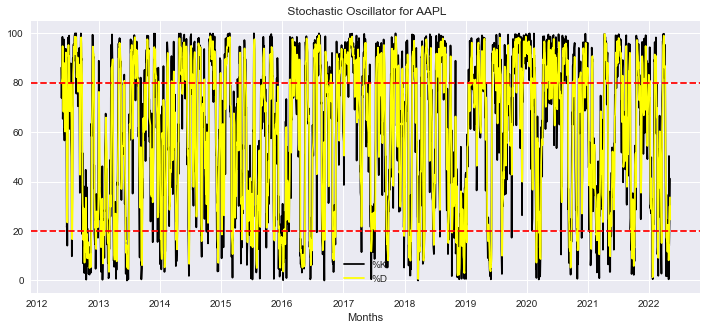

In [54]:
#Plotting SO Graph
plt.figure(figsize=(12, 5))
plt.title(' Stochastic Oscillator for AAPL')
plt.xlabel('Months')
plt.plot(dataset['%K'], label='%K', c='black')
plt.plot(dataset['%D'], label='%D',  c='yellow')
plt.axhline(20, linestyle='--', color="r")
plt.axhline(80, linestyle="--", color="r")
plt.legend()
plt.show()


In [55]:
# Adding Buy/Sell Signals from Sotchastic Oscillator Indicator
def categorise_so(row):  
    if row['%K'] <= 20 and row['%D'] <= 20:
        return 'Buy'
    elif row['%K'] >= 80 and  row['%D']>= 80:
        return 'Sell'
    else:
        return 'Hold'

    
   
dataset['SO Indicator'] = dataset.apply(lambda row: categorise_so(row), axis=1)


In [56]:
# Distrubition of the Indicator
print(dataset['SO Indicator'].value_counts())

Hold    1552
Sell     725
Buy      240
Name: SO Indicator, dtype: int64


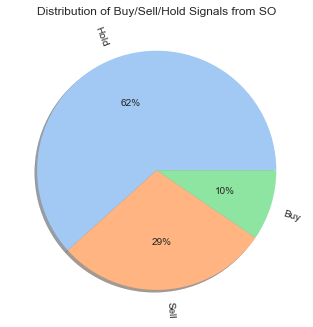

In [57]:
#Distrubition of the SO Indicator
labels = ["Hold", "Sell", "Buy"]
values = dataset['SO Indicator'].value_counts().tolist()
colours = sns.color_palette("pastel")
plt.pie(x=values, labels=labels, autopct='%.0f%%', colors= colours, shadow=True, rotatelabels='true')
plt.title("Distribution of Buy/Sell/Hold Signals from SO")
plt.show()

Relative Strength Index

In [58]:
delta = dataset['Close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down
dataset['RSI'] = 100 - (100/(1 + rs))

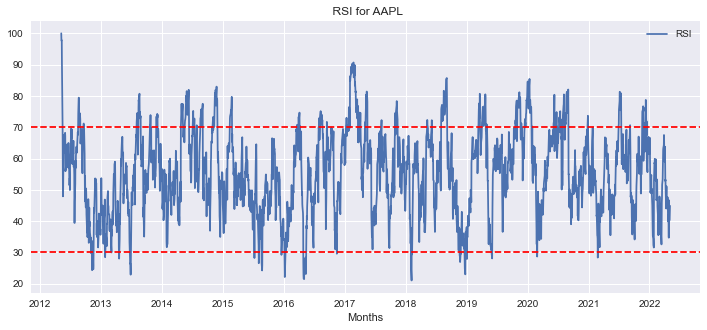

In [59]:
#Plotting RSI Graph
plt.figure(figsize=(12, 5))
plt.title(' RSI for AAPL')
plt.xlabel('Months')
plt.plot(dataset['RSI'], label='RSI')
plt.axhline(30, linestyle='--', color="r")
plt.axhline(70, linestyle="--", color="r")
plt.legend()
plt.show()



In [60]:
# Adding Buy/Sell Signals from RSI Indicator
def categorise_rsi(row):  
    if row['RSI'] <= 30:
        return 'Buy'
    elif row['RSI'] >= 70:
        return 'Sell'
    else:
        return 'Hold'
  
dataset['RSI Indicator'] = dataset.apply(lambda row: categorise_rsi(row), axis=1)

In [61]:
# Distrubition of the Indicator
print(dataset['RSI Indicator'].value_counts())

Hold    2086
Sell     369
Buy       62
Name: RSI Indicator, dtype: int64


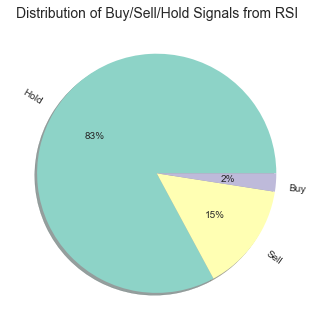

In [62]:
#Distrubition of the Indicator
labels = ["Hold", "Sell", "Buy"]
values = dataset['RSI Indicator'].value_counts().tolist()
plt.style.use("seaborn")
colours = sns.color_palette("Set3")
plt.pie(x=values, labels=labels, autopct='%.0f%%', colors= colours, shadow=True, rotatelabels='true')
plt.title("Distribution of Buy/Sell/Hold Signals from RSI", fontdict={'fontsize': 14})
plt.show()

Bollinger Bands

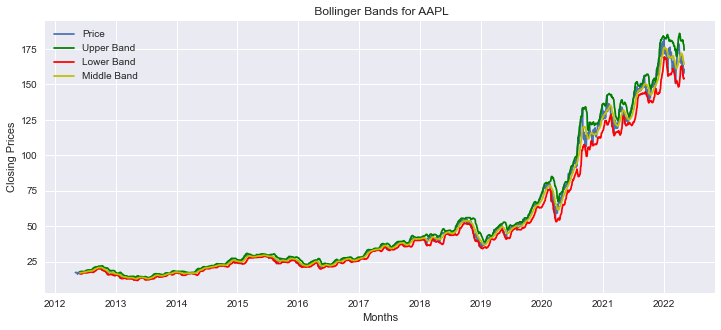

In [63]:
def get_sma(prices, rate):
    return prices.rolling(rate).mean()

def get_bollinger_bands(prices, rate=20):
    # SMA for 20 Days (Middle Band)
    sma = get_sma(prices, rate)
    std = prices.rolling(rate).std()

    # Calculating Upper Band
    bollinger_upper = sma + (std * 2 )

    # Calculate Lower Band
    bollinger_lower = sma - (std * 2 )

    #Middle Band
    bollinger_middle = sma
    return bollinger_upper, bollinger_lower, bollinger_middle


closing_prices = dataset['Close']
bollinger_upper, bollinger_lower, bollinger_middle = get_bollinger_bands(closing_prices)

#Plotting the  Bollinger Bands
plt.figure(figsize=(12, 5))
plt.title(' Bollinger Bands for AAPL')
plt.xlabel('Months')
plt.ylabel('Closing Prices')
plt.plot(closing_prices, label='Price')
plt.plot(bollinger_upper, label='Upper Band', c='g')
plt.plot(bollinger_lower, label='Lower Band', c='r')
plt.plot(bollinger_middle, label='Middle Band', c='y')

plt.legend()
plt.show()

In [64]:
#Adding Bollinger Bands to the Dataset
dataset['Bollinger_Upper'] = bollinger_upper
dataset['Bollinger_Lower'] = bollinger_lower


In [65]:
# Adding Buy/Sell Signals from Bollinger Bands Indicator
def categorise_bollinger(row):  
    if row['Close'] < row['Bollinger_Lower']:
        return 'Buy'
    elif row['Close'] > row['Bollinger_Upper']:
        return 'Sell'
    else:
        return 'Hold'
    
   
dataset['Bollinger Indicator'] = dataset.apply(lambda row: categorise_bollinger(row), axis=1)


In [66]:
# Distrubition of the Indicator
print(dataset['Bollinger Indicator'].value_counts())

Hold    2219
Sell     188
Buy      110
Name: Bollinger Indicator, dtype: int64


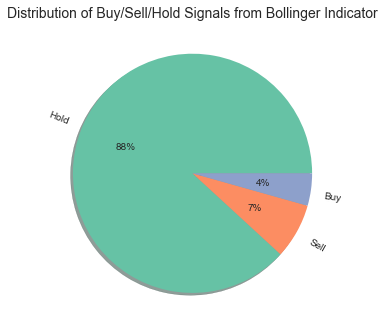

In [67]:
#Distrubition of the Indicator
labels = ["Hold", "Sell", "Buy"]
values = dataset['Bollinger Indicator'].value_counts().tolist()
plt.style.use("seaborn")
colours = sns.color_palette("Set2")
plt.pie(x=values, labels=labels, autopct='%.0f%%', colors= colours, shadow=True, rotatelabels='true')
plt.title("Distribution of Buy/Sell/Hold Signals from Bollinger Indicator", fontdict={'fontsize': 14})
plt.show()

Moving Average Convergence Divergence

In [68]:
# Calculating the MACD Line and the Signal Line
ema12 = dataset['Close'].ewm(span=12, adjust=False).mean()
ema26 = dataset['Close'].ewm(span=26, adjust=False).mean()
macd = ema12 - ema26
signal = macd.ewm(span=9, adjust=False).mean()


#Appeding the MACD and Signal Data to Dataset
dataset['MACD'] = macd
dataset['Signal'] = signal


In [69]:
# Adding Buy/Sell Signals from MACD
signal = []

for i in range(len(dataset)):
   if dataset['MACD'][i] > dataset['Signal'][i] and dataset['MACD'][i-1] < dataset['Signal'][i-1]:
      signal.append('Buy')
   elif dataset['MACD'][i] < dataset['Signal'][i] and dataset['MACD'][i-1] > dataset['Signal'][i-1]:
      signal.append('Sell')
   else:
      signal.append('Hold')

  
    
dataset['MACD Indicator'] = signal

In [70]:
# Distrubition of the Indicator
print(dataset['MACD Indicator'].value_counts())

Hold    2342
Sell      88
Buy       87
Name: MACD Indicator, dtype: int64


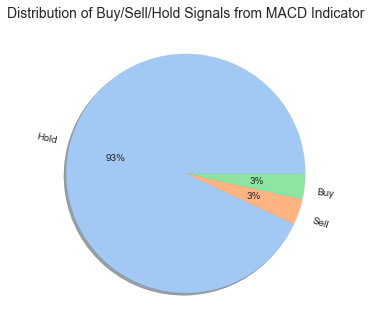

In [71]:
#Distrubition of the MACD Indicator
labels = ["Hold", "Sell", "Buy"]
values = dataset['MACD Indicator'].value_counts().tolist()
colours = sns.color_palette("pastel", 10)
plt.pie(x=values, labels=labels, autopct='%.0f%%', colors= colours, shadow=True, rotatelabels='true')
plt.title("Distribution of Buy/Sell/Hold Signals from MACD Indicator", fontdict={'fontsize': 14})
plt.show()

Addding Target Variable

In [72]:
# Recommender Based on the three indicators
def recommender(row): 
    # If All Share the Same Signal OutPut That Signal (Buy)
    if row['RSI Indicator'] == "Buy" and row['SO Indicator'] == 'Buy' and  row['Bollinger Indicator'] == 'Buy':
        return 'Buy'
     # If Any 2 Indicators Share the Same Signal Output That Signal (buy)
    elif row['RSI Indicator'] == 'Buy' and row['SO Indicator'] == 'Buy':
        return 'Buy'
    elif row['RSI Indicator'] == 'Buy' and row['Bollinger Indicator'] == 'Buy':
        return 'Buy'
    elif row['SO Indicator'] == 'Buy' and row['Bollinger Indicator'] == 'Buy':
        return 'Buy'   
    # If All Share the Same Signal Output That Signal (Sell)
    elif row['RSI Indicator'] == 'Sell' and row['SO Indicator'] == 'Sell' and  row['Bollinger Indicator'] == 'Sell':
        return 'Sell'
    # If Any 2 Indicators Share the Same Signal Output That Signal (Sell)
    elif row['RSI Indicator'] == 'Sell' and row['SO Indicator'] == 'Sell':
        return 'Sell'
    elif row['RSI Indicator'] == 'Sell' and row['Bollinger Indicator'] == 'Sell':
        return 'Sell'
    elif row['SO Indicator'] == 'Sell' and row['Bollinger Indicator'] == 'Sell':
        return 'Sell'    
    # If All Share the Same Signal OutPut That Signal (Hold)
    elif row['RSI Indicator'] == 'Hold' and row['SO Indicator'] == 'Hold' and  row['Bollinger Indicator'] == 'Hold':
        return 'Hold'
    # If Any 2 Indicators Share the Same Signal Output That Signal (Hold)
    elif row['RSI Indicator'] == 'Hold' and row['SO Indicator'] == 'Hold':
        return 'Hold'
    elif row['RSI Indicator'] == 'Hold' and row['Bollinger Indicator'] == 'Hold':
        return 'Hold'
    elif row['SO Indicator'] == 'Hold' and row['Bollinger Indicator'] == 'Hold':
        return 'Hold'      
    else:
        return 'Unclassed'

dataset['Recommender'] = dataset.apply(lambda row: recommender(row), axis=1)

In [73]:
# Distrubition of the Recommender
print(dataset['Recommender'].value_counts())


Hold    2016
Sell     390
Buy      111
Name: Recommender, dtype: int64


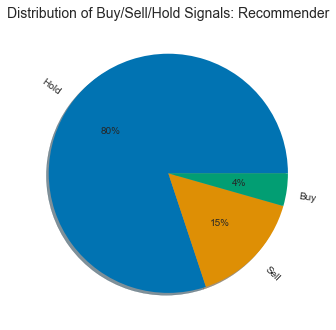

In [74]:
#Distrubition of the Recommender
labels = ["Hold", "Sell", "Buy"]
values = dataset['Recommender'].value_counts().tolist()
plt.style.use("seaborn")
colours = sns.color_palette("colorblind" )
plt.pie(x=values, labels=labels, autopct='%.0f%%', colors= colours, shadow=True, rotatelabels='true')
plt.title("Distribution of Buy/Sell/Hold Signals: Recommender", fontdict={'fontsize': 14})
plt.show()

Data Cleaning and Preprocessing

In [75]:
dataset.drop(['RSI Indicator', 'SO Indicator', 'MACD Indicator' , 'Bollinger Indicator'], axis = 1, inplace=True)

In [76]:
#Dataset shape after adding all the technical indicators 
dataset.shape

(2517, 13)

In [77]:
#Columns After Adding All The Technical Indicators
dataset.columns

Index(['Open', 'Close', 'High', 'Low', 'Volume', '%K', '%D', 'RSI',
       'Bollinger_Upper', 'Bollinger_Lower', 'MACD', 'Signal', 'Recommender'],
      dtype='object')

In [78]:
#Information regarding the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2012-05-04 to 2022-05-04
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2517 non-null   float64
 1   Close            2517 non-null   float64
 2   High             2517 non-null   float64
 3   Low              2517 non-null   float64
 4   Volume           2517 non-null   int64  
 5   %K               2504 non-null   float64
 6   %D               2502 non-null   float64
 7   RSI              2516 non-null   float64
 8   Bollinger_Upper  2498 non-null   float64
 9   Bollinger_Lower  2498 non-null   float64
 10  MACD             2517 non-null   float64
 11  Signal           2517 non-null   float64
 12  Recommender      2517 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 275.3+ KB


In [79]:
#Checking for Null Values
dataset.isna().sum()

Open                0
Close               0
High                0
Low                 0
Volume              0
%K                 13
%D                 15
RSI                 1
Bollinger_Upper    19
Bollinger_Lower    19
MACD                0
Signal              0
Recommender         0
dtype: int64

In [80]:
#Dropping Null Values
dataset = dataset.dropna()
dataset.isna().sum()

Open               0
Close              0
High               0
Low                0
Volume             0
%K                 0
%D                 0
RSI                0
Bollinger_Upper    0
Bollinger_Lower    0
MACD               0
Signal             0
Recommender        0
dtype: int64

In [81]:
#let's check if there is any duplicate data
print(dataset.duplicated().any())
print(dataset.duplicated().sum())

False
0


In [82]:
#Dataframe after dopping null values
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2498 entries, 2012-06-01 to 2022-05-04
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2498 non-null   float64
 1   Close            2498 non-null   float64
 2   High             2498 non-null   float64
 3   Low              2498 non-null   float64
 4   Volume           2498 non-null   int64  
 5   %K               2498 non-null   float64
 6   %D               2498 non-null   float64
 7   RSI              2498 non-null   float64
 8   Bollinger_Upper  2498 non-null   float64
 9   Bollinger_Lower  2498 non-null   float64
 10  MACD             2498 non-null   float64
 11  Signal           2498 non-null   float64
 12  Recommender      2498 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 273.2+ KB


In [83]:
# #Encode Categorical Variables
signal_dict = {'Hold': 0, 'Sell': 1, 'Buy': 2}

dataset['Recommender'] = dataset['Recommender'].map(signal_dict)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2498 entries, 2012-06-01 to 2022-05-04
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2498 non-null   float64
 1   Close            2498 non-null   float64
 2   High             2498 non-null   float64
 3   Low              2498 non-null   float64
 4   Volume           2498 non-null   int64  
 5   %K               2498 non-null   float64
 6   %D               2498 non-null   float64
 7   RSI              2498 non-null   float64
 8   Bollinger_Upper  2498 non-null   float64
 9   Bollinger_Lower  2498 non-null   float64
 10  MACD             2498 non-null   float64
 11  Signal           2498 non-null   float64
 12  Recommender      2498 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 273.2 KB


In [84]:
# #Splitting the dataset into training and test sets
# #Feature Scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE

#Independant and Dependent Variable
y=dataset.iloc[:,12:13] #Dependent variable
X=dataset.iloc[:,0:12] #Independent variable

#Spliting the data into train and test
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)


#Scaling
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [85]:
# Shape of Training and Test sets
print("x_train dataset: ", X_train.shape)
print(" y_train dataset: ", y_train.shape)
print(" x_test dataset: ", X_test.shape)
print("y_test dataset: ", y_test.shape)

x_train dataset:  (1748, 12)
 y_train dataset:  (1748, 1)
 x_test dataset:  (750, 12)
y_test dataset:  (750, 1)


In [86]:
y_train['Recommender'].value_counts()


0    1394
1     277
2      77
Name: Recommender, dtype: int64

In [87]:
y_test['Recommender'].value_counts()

0    603
1    113
2     34
Name: Recommender, dtype: int64

Text(0.5, 0, 'Trade Signals')

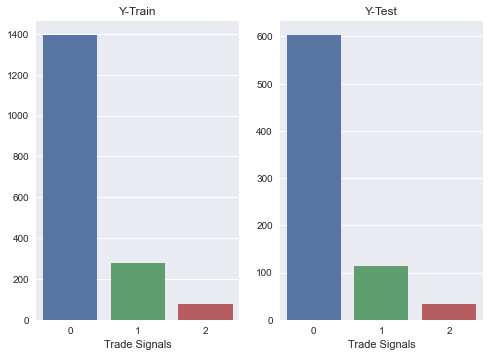

In [88]:
#Original Dataset  
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(x=['0', '1','2'], y =[sum(y_train['Recommender'] == 0), sum(y_train['Recommender'] == 1), sum(y_train['Recommender'] == 2)], ax = ax1)
ax1.set_title("Y-Train")
ax1.set_xlabel('Trade Signals')

sns.barplot(x=['0', '1', '2'], y =[sum(y_test['Recommender'] == 0), sum(y_test['Recommender'] == 1), sum(y_test['Recommender'] == 2)], ax = ax2)
ax2.set_title("Y-Test")
ax2.set_xlabel('Trade Signals')

Text(0.5, 0, 'Trade Signals')

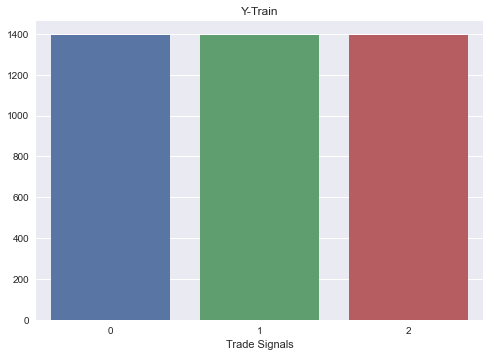

In [89]:
#Handling Imbalance data using SMOTE
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE


oversample = SMOTE()
Xsmote, ysmote = oversample.fit_resample(X_train, y_train)


fig = sns.barplot(x=['0', '1', '2'],  y =[sum(ysmote['Recommender'] == 0), sum(ysmote['Recommender'] == 1), sum(ysmote['Recommender'] == 2)])
fig.set_title("Y-Train")
fig.set_xlabel('Trade Signals')

Exploring Models on Original Dataset without using SMOTE

In [90]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
k = 10
#Logistic Regression
lr = LogisticRegression(multi_class = "ovr")
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    
     
    lr.fit(X_train,y_train.values.ravel())
    y_pred = lr.predict(X_test)

    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)


#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))

#Storing Results for the Model
list_1 = []
list_2 = []

#Results
list_2.append("Logistic Regression")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []



C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\User

Accuracy of each fold - [0.892, 0.904, 0.892, 0.912, 0.884, 0.868, 0.864, 0.904, 0.9036144578313253, 0.9196787148594378]
Precision of each fold - [0.6270190895741556, 0.6309523809523809, 0.6148148148148148, 0.6336336336336337, 0.6110579071697632, 0.5897969085742011, 0.6007343550446999, 0.6307922272047833, 0.6031586021505376, 0.6362252663622526]
Recall of each fold - [0.5299145299145299, 0.5555555555555555, 0.5367948717948718, 0.5726495726495727, 0.5197008547008547, 0.4923931623931624, 0.47696581196581195, 0.5641025641025641, 0.5761714555684405, 0.5897435897435898]
F1 of each fold - [0.5595678779179573, 0.5811320754716981, 0.562156862745098, 0.5945627313668623, 0.5472539094961094, 0.5188034188034188, 0.5059291747888239, 0.5871032600890421, 0.5864030335861322, 0.6072394424797171]
Avg Accuracy : 0.8943
Avg Recall : 0.5414
Avg Precision: 0.6178
Avg F1 : 0.565


C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
k = 10

#Decision Tree
decision_tree = DecisionTreeClassifier()
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    
     
    decision_tree.fit(X_train,y_train)
    y_pred = decision_tree.predict(X_test)

    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)


#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))


#Results
list_2.append("Decision Tree")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []



Accuracy of each fold - [0.936, 0.936, 0.924, 0.936, 0.912, 0.928, 0.908, 0.916, 0.9518072289156626, 0.9477911646586346]
Precision of each fold - [0.8542815542815543, 0.9015780486368721, 0.8601174345076784, 0.826352960499302, 0.8320498716538319, 0.89592643961576, 0.8308393759613272, 0.8014662524629301, 0.8549482844166253, 0.8232305069394497]
Recall of each fold - [0.9251709401709401, 0.8392618492618492, 0.7987451437451437, 0.8381468531468531, 0.8372571872571872, 0.8221678321678322, 0.7565617715617715, 0.8068225744105142, 0.9020276206205855, 0.8637125019034566]
F1 of each fold - [0.8826860347622049, 0.8675004342539516, 0.8265843621399177, 0.8320542104461702, 0.8337385536087677, 0.8554919451471176, 0.7880875027073856, 0.8030632105990846, 0.874920634920635, 0.8422787613206367]
Avg Accuracy : 0.9296
Avg Recall : 0.839
Avg Precision: 0.8481
Avg F1 : 0.8406


In [92]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
k = 10

#Random Forest
rf= RandomForestClassifier()
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    
     
    rf.fit(X_train,y_train.values.ravel())
    y_pred = rf.predict(X_test)

    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)


#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))


#Results
list_2.append("Random Forest")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []

Accuracy of each fold - [0.944, 0.956, 0.944, 0.96, 0.944, 0.924, 0.932, 0.94, 0.963855421686747, 0.9598393574297188]
Precision of each fold - [0.9601190476190476, 0.9826224328593997, 0.8823529411764706, 0.9234323432343233, 0.9074298813376483, 0.849960876369327, 0.914711053355756, 0.8672123969153672, 0.9782830863566684, 0.8773946360153256]
Recall of each fold - [0.828834498834499, 0.8407148407148407, 0.8712315462315462, 0.855027195027195, 0.8861072261072261, 0.7277117327117327, 0.7883177933177933, 0.8361035948975647, 0.7994127592117541, 0.8263657057626906]
F1 of each fold - [0.8843431147432305, 0.9003518528681802, 0.8748891863575875, 0.8828917813773681, 0.8933842937686086, 0.77775070777642, 0.8413503344736538, 0.850994177409261, 0.8546055796055795, 0.8496028628785895]
Avg Accuracy : 0.9468
Avg Recall : 0.826
Avg Precision: 0.9144
Avg F1 : 0.861


In [93]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
k = 10 
#Support Vector Machine
svc = SVC()
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    
     
    svc.fit(X_train,y_train.values.ravel())
    y_pred = svc.predict(X_test)
    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)


#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))


#Results
list_2.append("Support Vector Machine")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []

Accuracy of each fold - [0.912, 0.948, 0.932, 0.944, 0.92, 0.888, 0.904, 0.944, 0.927710843373494, 0.9357429718875502]
Precision of each fold - [0.9177148846960167, 0.9493298176225006, 0.8987804878048781, 0.9425590749120162, 0.8581790611493583, 0.7823412698412698, 0.8714285714285714, 0.8894294916034046, 0.9363309798092407, 0.9582752532292537]
Recall of each fold - [0.7810994560994562, 0.8511421911421913, 0.8307148407148407, 0.8277195027195027, 0.8474708624708626, 0.6920707070707071, 0.6780963480963481, 0.7855731649701498, 0.7064655054604803, 0.7246996442976342]
F1 of each fold - [0.8377816286882961, 0.8928091834524583, 0.8615637860082304, 0.8716397280753716, 0.8526347528704167, 0.7301391575813461, 0.7467827274278888, 0.8281453867660765, 0.752010441665614, 0.7903404239521846]
Avg Accuracy : 0.9255
Avg Recall : 0.7725
Avg Precision: 0.9004
Avg F1 : 0.8164


In [94]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
k = 10
#K-Nearest Neighbour
knn = KNeighborsClassifier()
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    
     
    knn.fit(X_train, y_train.values.ravel())
    y_pred = knn.predict(X_test)
    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)


#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))


#Results
list_2.append("K-Nearest Neighbour")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []

Accuracy of each fold - [0.932, 0.956, 0.928, 0.924, 0.916, 0.892, 0.912, 0.94, 0.9317269076305221, 0.9598393574297188]
Precision of each fold - [0.9186238371072495, 0.9534180278281911, 0.8795724232617438, 0.873650198040442, 0.8550522648083625, 0.7568120226656813, 0.900167745027558, 0.8892156862745099, 0.8692126355492693, 0.9438546150167384]
Recall of each fold - [0.810073815073815, 0.88999222999223, 0.8439238539238539, 0.7552331002331002, 0.8102874902874904, 0.7361344211344211, 0.795975135975136, 0.8292316282266031, 0.750512469105434, 0.8847618043597943]
F1 of each fold - [0.8567438908283086, 0.9186071992523606, 0.8598007994559719, 0.7958251866748599, 0.8312788979455646, 0.7442834138486313, 0.8372316894056024, 0.85668396120009, 0.7821649579754318, 0.9121666569788095]
Avg Accuracy : 0.9292
Avg Recall : 0.8106
Avg Precision: 0.884
Avg F1 : 0.8395


In [95]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
k = 10

#GaussianNB
gnb = GaussianNB()
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    
     
    gnb.fit(X_train, y_train.values.ravel())
    y_pred = gnb.predict(X_test)
    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)


#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))


#Results
list_2.append("GaussianNB")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []

Accuracy of each fold - [0.812, 0.824, 0.86, 0.812, 0.788, 0.772, 0.824, 0.82, 0.8273092369477911, 0.8473895582329317]
Precision of each fold - [0.6478821094836228, 0.6552884615384615, 0.6955929772096656, 0.6531702761371094, 0.6281240854550775, 0.6024947319547126, 0.6502366463826911, 0.6446749710707236, 0.6477945971921876, 0.6826566646925928]
Recall of each fold - [0.8231118881118881, 0.8911499611499613, 0.9061499611499612, 0.8930303030303031, 0.8910256410256411, 0.8270862470862471, 0.8567482517482518, 0.825699007859812, 0.8065892789510879, 0.9157325086973328]
F1 of each fold - [0.7044246291925286, 0.718727465329407, 0.7622399538775846, 0.7160417047740992, 0.6885630019376787, 0.6471685451951862, 0.7048048048048048, 0.6992975642682101, 0.6985732107602679, 0.7495547316082259]
Avg Accuracy : 0.8187
Avg Recall : 0.8636
Avg Precision: 0.6508
Avg F1 : 0.7089


In [96]:

#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
k = 10


#MLP
mlp = MLPClassifier()


acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    
     
    mlp.fit(X_train,y_train.values.ravel())
    y_pred = mlp.predict(X_test)
    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test.values.ravel())
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test.values.ravel(), y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)


#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))


#Results
list_2.append("MLP")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []

C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

Accuracy of each fold - [0.904, 0.944, 0.924, 0.944, 0.932, 0.888, 0.916, 0.96, 0.9236947791164659, 0.9477911646586346]
Precision of each fold - [0.8496598639455782, 0.9367986798679868, 0.8390736634639073, 0.9327777777777778, 0.8493284493284493, 0.7497573286740439, 0.8582604630699006, 0.9062890674830975, 0.9312678062678064, 0.8845811051693405]
Recall of each fold - [0.8259285159285158, 0.8563558663558664, 0.8205011655011655, 0.8632362082362083, 0.9086285936285936, 0.7631041181041182, 0.8182828282828284, 0.8650947042906841, 0.7414305404255153, 0.8511086903046703]
F1 of each fold - [0.8337662337662337, 0.8893462953940049, 0.8273573089998211, 0.8904342646740308, 0.8766005104964316, 0.7524905154592335, 0.8319899449096105, 0.8836635586635585, 0.8016612066612067, 0.8663747505992315]
Avg Accuracy : 0.9283
Avg Recall : 0.8314
Avg Precision: 0.8738
Avg F1 : 0.8454


C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [97]:
#Displaying all the results from the model
model_results = pd.DataFrame(list_1, columns= ['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
model_results.sort_values(by= ['F1'], inplace= True, ascending= False)
model_results

,Model,Accuracy,Precision,Recall,F1
2,Random Forest,0.9468,0.9144,0.8260,0.8610
6,MLP,0.9283,0.8738,0.8314,0.8454
1,Decision Tree,0.9296,0.8481,0.8390,0.8406
4,K-Nearest Neighbour,0.9292,0.8840,0.8106,0.8395
3,Support Vector Machine,0.9255,0.9004,0.7725,0.8164
5,GaussianNB,0.8187,0.6508,0.8636,0.7089
0,Logistic Regression,0.8943,0.6178,0.5414,0.5650


Models using SMOTE to balance dataset so there are equal amount of trading signals

In [98]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
kf = KFold(n_splits=10, shuffle=True, random_state=None)
k = 10

#Logistic Regression
lr = LogisticRegression(multi_class = "ovr")
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)   

    #Smote
    oversample = SMOTE()
    Xsmote, ysmote = oversample.fit_resample(X_train, y_train) 

     
    lr.fit(Xsmote,ysmote.values.ravel())
    y_pred = lr.predict(X_test)

    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)

#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))

#Storing Results for the Model
list_1 = []
list_2 = []

#Results
list_2.append("Logistic Regression")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []


Accuracy of each fold - [0.772, 0.8, 0.82, 0.804, 0.756, 0.732, 0.78, 0.78, 0.8032128514056225, 0.7991967871485943]
Precision of each fold - [0.6149118858478465, 0.6369001547987616, 0.6522318023319168, 0.6427893738140417, 0.6033676759181384, 0.5975676823852006, 0.620727910794136, 0.6299272866437046, 0.6405954790823212, 0.6387281669958561]
Recall of each fold - [0.8694832944832944, 0.9097863247863248, 0.9043589743589745, 0.9183333333333333, 0.8776923076923078, 0.8745726495726496, 0.8876923076923077, 0.9078726968174204, 0.9110509814027402, 0.9093759395266933]
F1 of each fold - [0.6694337473328061, 0.6949025040044458, 0.7123247224548518, 0.7043934489417355, 0.6484314850292056, 0.6291109591345091, 0.6701925235258569, 0.6820291458901621, 0.7009319993816118, 0.6912664055521197]
Avg Accuracy : 0.7846
Avg Recall : 0.897
Avg Precision: 0.6278
Avg F1 : 0.6803


In [99]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
k = 10

#Decision Tree
decision_tree = DecisionTreeClassifier()
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)   

    #Smote
    oversample = SMOTE()
    Xsmote, ysmote = oversample.fit_resample(X_train, y_train)  
     
    decision_tree.fit(Xsmote,ysmote)
    y_pred = decision_tree.predict(X_test)

    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)

#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))

#Results
list_2.append("Decision Tree")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []


Accuracy of each fold - [0.94, 0.94, 0.936, 0.9, 0.888, 0.92, 0.924, 0.928, 0.9196787148594378, 0.9518072289156626]
Precision of each fold - [0.8570005755935405, 0.8526239296783343, 0.8417696025778733, 0.7555172600022585, 0.757463768115942, 0.7882672882672882, 0.8243207097162473, 0.8129671182027204, 0.802299358582081, 0.8506185335132703]
Recall of each fold - [0.9050815850815851, 0.9326029526029526, 0.932051282051282, 0.8655439005439005, 0.8902952602952604, 0.8177195027195027, 0.8273815073815074, 0.8777971051840399, 0.8817553189412486, 0.9306556090475689]
F1 of each fold - [0.8769423558897244, 0.8885194657573173, 0.8771845438512105, 0.8002709350285692, 0.8106230059647662, 0.8016256496155995, 0.8229451110582353, 0.8423687423687425, 0.8373638142312841, 0.8817829410045991]
Avg Accuracy : 0.9247
Avg Recall : 0.8861
Avg Precision: 0.8143
Avg F1 : 0.844


In [100]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
k = 10


#Random Forest
rf= RandomForestClassifier()
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    

    oversample = SMOTE()
    Xsmote, ysmote = oversample.fit_resample(X_train, y_train)  
     
    rf.fit(Xsmote,ysmote.values.ravel())
    y_pred = rf.predict(X_test)

    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)

#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))

#Results
list_2.append("Random Forest")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []


Accuracy of each fold - [0.944, 0.948, 0.932, 0.944, 0.928, 0.928, 0.94, 0.916, 0.9477911646586346, 0.9759036144578314]
Precision of each fold - [0.8649740649740649, 0.8729500195236236, 0.8466352005224568, 0.8172123015873015, 0.8345238095238096, 0.8178417841784178, 0.843595746756414, 0.7960336634515489, 0.8799768518518518, 0.8941239316239317]
Recall of each fold - [0.9353846153846154, 0.9221756021756021, 0.9235042735042734, 0.9125135975135975, 0.9000815850815851, 0.8359285159285159, 0.8764452214452215, 0.832925310312245, 0.9358525338424836, 0.983077782072757]
F1 of each fold - [0.8931330064628135, 0.8955545635869585, 0.8781671728775002, 0.856407995296884, 0.8633294975067128, 0.8198324616235064, 0.8530035991860881, 0.8134078073605164, 0.9057565055007509, 0.9288664584772875]
Avg Accuracy : 0.9404
Avg Recall : 0.9058
Avg Precision: 0.8468
Avg F1 : 0.8707


In [101]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
k = 10

#Support Vector Machine
svc = SVC()
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)  

    oversample = SMOTE()
    Xsmote, ysmote = oversample.fit_resample(X_train, y_train)    
     
    svc.fit(Xsmote,ysmote.values.ravel())
    y_pred = svc.predict(X_test)
    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)

#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))

#Results
list_2.append("Support Vector Machine")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []


Accuracy of each fold - [0.86, 0.892, 0.876, 0.86, 0.88, 0.848, 0.852, 0.868, 0.8875502008032129, 0.891566265060241]
Precision of each fold - [0.7037055000485014, 0.7446839320523532, 0.7247625256099832, 0.7063492063492064, 0.7242524916943521, 0.6770885547201336, 0.6874201988487703, 0.708264915161467, 0.7321428571428571, 0.7291358024691358]
Recall of each fold - [0.9061499611499612, 0.9263636363636364, 0.9208119658119659, 0.9416666666666668, 0.9431196581196581, 0.8942696192696192, 0.897051282051282, 0.9186208821887214, 0.9530988274706867, 0.9547738693467336]
F1 of each fold - [0.7701034472710319, 0.8100517241379311, 0.7915008841732979, 0.7784940460202345, 0.7953405017921146, 0.7410426731078905, 0.7486426426426426, 0.7751055221068422, 0.8040145408566461, 0.7941918608265417]
Avg Accuracy : 0.8715
Avg Recall : 0.9256
Avg Precision: 0.7138
Avg F1 : 0.7808


In [102]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
k = 10

#K-Nearest Neighbour
knn = KNeighborsClassifier()
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    

    oversample = SMOTE()
    Xsmote, ysmote = oversample.fit_resample(X_train, y_train)    
     
    knn.fit(Xsmote, ysmote.values.ravel())
    y_pred = knn.predict(X_test)
    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)

#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))

#Results
list_2.append("K-Nearest Neighbour")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []



Accuracy of each fold - [0.892, 0.892, 0.916, 0.88, 0.904, 0.864, 0.88, 0.912, 0.891566265060241, 0.9317269076305221]
Precision of each fold - [0.7503003003003004, 0.7522202342555064, 0.8137032085561496, 0.733247200689061, 0.7611721611721611, 0.6960858585858585, 0.7322923855532552, 0.7622963388920835, 0.7455183861082738, 0.7940037016123972]
Recall of each fold - [0.9137179487179488, 0.9126029526029527, 0.9374786324786325, 0.9213636363636364, 0.9393589743589743, 0.8871756021756022, 0.9018376068376068, 0.8779689043508139, 0.8906459258218052, 0.9646523214362409]
F1 of each fold - [0.8084206116464182, 0.812914844492, 0.8654959938039329, 0.7989629330007529, 0.8248121337068334, 0.7558399644820873, 0.7904265873015873, 0.8088097545219638, 0.8011864226097535, 0.8529254092086361]
Avg Accuracy : 0.8963
Avg Recall : 0.9147
Avg Precision: 0.7541
Avg F1 : 0.812


In [103]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
k = 10 
#GaussianNB
gnb = GaussianNB()
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    

    oversample = SMOTE()
    Xsmote, ysmote = oversample.fit_resample(X_train, y_train)    
     
    gnb.fit(Xsmote, ysmote.values.ravel())
    y_pred = gnb.predict(X_test)
    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)

#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))

#Results
list_2.append("GaussianNB")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []



Accuracy of each fold - [0.796, 0.804, 0.844, 0.792, 0.764, 0.748, 0.82, 0.808, 0.8072289156626506, 0.8313253012048193]
Precision of each fold - [0.6353367433930094, 0.647909534184044, 0.6869881992581379, 0.6410526315789474, 0.6090702947845804, 0.5855582178890449, 0.6463048745276742, 0.6368667810177243, 0.6293632632305401, 0.6653239521078723]
Recall of each fold - [0.8302059052059052, 0.9114529914529914, 0.9063636363636364, 0.8846969696969698, 0.8810256410256411, 0.8170862470862471, 0.8619619269619271, 0.8344178155735945, 0.7982140695708534, 0.9227762745350686]
F1 of each fold - [0.6918104564164963, 0.7124616255142625, 0.7534730421094058, 0.7003726708074535, 0.6635072134239307, 0.6260328117059283, 0.7014398363388917, 0.6920725993351692, 0.6790123456790124, 0.7308938547486034]
Avg Accuracy : 0.8015
Avg Recall : 0.8648
Avg Precision: 0.6384
Avg F1 : 0.6951


In [104]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
kf = KFold
k = 10
#MLP
mlp = MLPClassifier()


acc_score = []
prec_score = []
rec_score = []
f1_scor = []


 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)  

    oversample = SMOTE()
    Xsmote, ysmote = oversample.fit_resample(X_train, y_train)    
     
    mlp.fit(Xsmote,ysmote.values.ravel())
    y_pred = mlp.predict(X_test)
    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test.values.ravel())
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test.values.ravel(), y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)

#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))

#Results
list_2.append("MLP")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []



C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of each fold - [0.856, 0.892, 0.888, 0.884, 0.88, 0.872, 0.9, 0.884, 0.8995983935742972, 0.9076305220883534]
Precision of each fold - [0.7124669312169312, 0.7522202342555064, 0.7406715714016223, 0.7252556129440286, 0.7389509389330864, 0.7122448979591837, 0.7676623260392894, 0.7302048726467332, 0.7654461279461279, 0.7508333333333334]
Recall of each fold - [0.9044832944832945, 0.9126029526029527, 0.8834149184149185, 0.8806332556332556, 0.9224786324786325, 0.8836285936285937, 0.9032905982905982, 0.9253210496929088, 0.9512519864278658, 0.9614740368509214]
F1 of each fold - [0.7765643877090581, 0.812914844492, 0.7932806974257751, 0.7828401102878639, 0.8049459397285483, 0.7711722488038277, 0.8135368651002675, 0.7966481130684647, 0.8334882204287927, 0.8154431673052364]
Avg Accuracy : 0.8863
Avg Recall : 0.9129
Avg Precision: 0.7396
Avg F1 : 0.8001


In [105]:
#Displaying all the results from the model
model_results = pd.DataFrame(list_1, columns= ['Models with SMOTE', 'Accuracy', 'Precision', 'Recall', 'F1'])
model_results.sort_values(by= ['F1'], inplace= True, ascending= False)
model_results

,Models with SMOTE,Accuracy,Precision,Recall,F1
2,Random Forest,0.9404,0.8468,0.9058,0.8707
1,Decision Tree,0.9247,0.8143,0.8861,0.8440
4,K-Nearest Neighbour,0.8963,0.7541,0.9147,0.8120
6,MLP,0.8863,0.7396,0.9129,0.8001
3,Support Vector Machine,0.8715,0.7138,0.9256,0.7808
5,GaussianNB,0.8015,0.6384,0.8648,0.6951
0,Logistic Regression,0.7846,0.6278,0.8970,0.6803


Expirement: Trading Signal: 60% Hold, 20% Buy , 20% Sell.

In [106]:
#Spliting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

In [107]:
y_train['Recommender'].value_counts()

0    1394
1     277
2      77
Name: Recommender, dtype: int64

In [108]:
y_test['Recommender'].value_counts()

0    603
1    113
2     34
Name: Recommender, dtype: int64

In [109]:
#Scaling
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 

#SMOTE
strategy = {0:1799, 1:899, 2:899}
oversample = SMOTE(sampling_strategy=strategy)

Xsmote, ysmote = oversample.fit_resample(X_train, y_train)

C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (1799) in class 0 will be larger than the number of samples in the majority class (class #0 -> 1394)
  warnings.warn(


In [110]:
ysmote['Recommender'].value_counts()

0    1799
2     899
1     899
Name: Recommender, dtype: int64

Text(0.5, 0, 'Trade Signals')

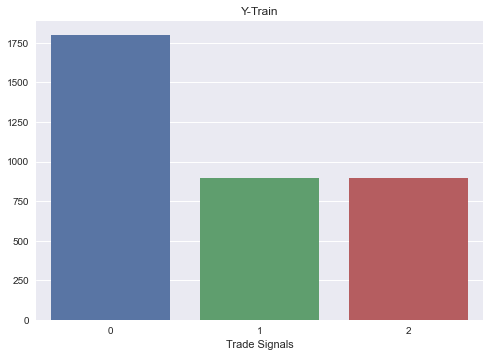

In [111]:
fig = sns.barplot(x=['0', '1', '2'],  y =[sum(ysmote['Recommender'] == 0), sum(ysmote['Recommender'] == 1), sum(ysmote['Recommender'] == 2)])
fig.set_title("Y-Train")
fig.set_xlabel('Trade Signals')

In [112]:
models = []
models.append(['Logistic Regreesion', LogisticRegression()])
models.append(['SVM', SVC()])
models.append(['KNeighbors', KNeighborsClassifier()])
models.append(['GaussianNB', GaussianNB()])
models.append(['Decision Tree', DecisionTreeClassifier()])
models.append(['Random Forest', RandomForestClassifier()])
models.append(['MLP', MLPClassifier()])


list_1= []

for m in range(len(models)):
    list_2= []
    
    model = models[m][1]
    model.fit(Xsmote, ysmote)
    y_pred = model.predict(X_test)

    #Accuracy
    accuracy = accuracy_score(y_pred , y_test.values.ravel())
    print(accuracy)
    #Precision
    test_precision = precision_score(y_test, y_pred,  average='macro')
    print("Test Data Precision Score :", test_precision) 
    #Recall
    test_recall = recall_score(y_test, y_pred,  average='macro')
    print("Test Data Recall Score : ", test_recall)
    #F1 Score
    test_f1 = f1_score(y_test, y_pred,average='macro')
    print("Test  Data F1 Score: ", test_f1)

    list_2.append(models[m][0])
    list_2.append(accuracy) 
    list_2.append(test_precision)
    list_2.append(test_recall)
    list_2.append(test_f1)
    list_1.append(list_2)





C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8693333333333333
Test Data Precision Score : 0.7042202460921673
Test Data Recall Score :  0.8776601117266348
Test  Data F1 Score:  0.7631264792263449


C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.888
Test Data Precision Score : 0.7396542436669994
Test Data Recall Score :  0.8761480641215232
Test  Data F1 Score:  0.7928138440177452
0.9133333333333333
Test Data Precision Score : 0.7885488007005034
Test Data Recall Score :  0.8845911572336709
Test  Data F1 Score:  0.829948161720263
0.8053333333333333
Test Data Precision Score : 0.6358101298141271
Test Data Recall Score :  0.8631114195924191
Test  Data F1 Score:  0.6964521371315527
0.9226666666666666
Test Data Precision Score : 0.8524469470592911
Test Data Recall Score :  0.8483848902862632
Test  Data F1 Score:  0.8499902345504503


C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\RAHUL\AppData\Local\Temp/ipykernel_12452/1504728737.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(Xsmote, ysmote)


0.9386666666666666
Test Data Precision Score : 0.8735997080824668
Test Data Recall Score :  0.8711235884893883
Test  Data F1 Score:  0.871752404598258


C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9106666666666666
Test Data Precision Score : 0.7991496598639456
Test Data Recall Score :  0.8595149649404662
Test  Data F1 Score:  0.8262900397915723


C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [113]:
#Displaying all the results from the model
model_results = pd.DataFrame(list_1, columns= ['Models with SMOTE 2', 'Accuracy', 'Precision', 'Recall', 'F1'])
model_results.sort_values(by= ['F1'], inplace= True, ascending= False)
model_results

,Models with SMOTE 2,Accuracy,Precision,Recall,F1
5,Random Forest,0.938667,0.873600,0.871124,0.871752
4,Decision Tree,0.922667,0.852447,0.848385,0.849990
2,KNeighbors,0.913333,0.788549,0.884591,0.829948
6,MLP,0.910667,0.799150,0.859515,0.826290
1,SVM,0.888000,0.739654,0.876148,0.792814
0,Logistic Regreesion,0.869333,0.704220,0.877660,0.763126
3,GaussianNB,0.805333,0.635810,0.863111,0.696452


Hyperparameter Tuning The Best Performing Model: Random Forest

In [114]:
X.shape


(2498, 12)

In [115]:
y.shape

(2498, 1)

In [116]:
#This Setup Achieved best performing model, we are running it again to check the models parameteres.

#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
k = 10


#Random Forest
rf= RandomForestClassifier()

acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 

for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    

    oversample = SMOTE()
    Xsmote, ysmote = oversample.fit_resample(X_train, y_train)  
     
    rf.fit(Xsmote,ysmote.values.ravel())
    y_pred = rf.predict(X_test)

    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)

#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))

avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print("Avg Accuracy Score: ", avg_acc_score)
print("Avg Recall Score: ", avg_rec_score)
print("Avg Precision Score: ", avg_prec_score)
print("Avg F1 Score: ", avg_f1_score)







Accuracy of each fold - [0.952, 0.948, 0.936, 0.948, 0.932, 0.924, 0.932, 0.924, 0.9477911646586346, 0.9678714859437751]
Precision of each fold - [0.9026819126819127, 0.8572738914202329, 0.8542815542815543, 0.8332112332112332, 0.8375949253998035, 0.8015912897822446, 0.837455579246624, 0.8055038144944643, 0.8632821865260129, 0.872078816912709]
Recall of each fold - [0.9387179487179487, 0.929055944055944, 0.9251709401709401, 0.8855439005439005, 0.9086285936285936, 0.8411421911421911, 0.8662315462315462, 0.8431473607353004, 0.9072245454155002, 0.9797276983206631]
F1 of each fold - [0.9183625730994152, 0.8890295358649789, 0.8826860347622049, 0.8573422930666249, 0.868987341772152, 0.8159218559218558, 0.8474902833007572, 0.8232342415027204, 0.8839896132117643, 0.9132216989359847]
Avg Accuracy Score:  0.9412
Avg Recall Score:  0.9025
Avg Precision Score:  0.8465
Avg F1 Score:  0.87


In [117]:
#Independant and Dependent Variable
y=dataset.iloc[:,12:13] #Dependent variable
X=dataset.iloc[:,0:12] #Independent variable


#Spliting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

#Scaling
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 

oversample = SMOTE()
Xsmote, ysmote = oversample.fit_resample(X_train, y_train)

In [118]:
ysmote['Recommender'].value_counts()

0    1394
2    1394
1    1394
Name: Recommender, dtype: int64

In [119]:
# Look at parameters used by our current RF Model
print('Parameters currently in use:\n')
print(rf.get_params())


Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [120]:
from sklearn.model_selection import RandomizedSearchCV

#5 Most Important Hyper Parameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
                }

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [123]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
rf_random_search = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random_search.fit(Xsmote, ysmote)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [124]:
#Random Search Best Paramters
# print the best parameters
print ('Best Parameters: ', rf_random_search.best_params_, ' \n')

Best Parameters:  {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}  



In [125]:
# #Using best parameters to make predictions
rs_rf = RandomForestClassifier(n_estimators= 800, min_samples_split= 2, min_samples_leaf= 1, max_features= 'sqrt', max_depth= None)
rs_rf.fit(Xsmote, ysmote.values.ravel())

#Accuracy
y_pred = rs_rf.predict(X_test)

accuracy = accuracy_score(y_pred , y_test)
print("Accuracy Score :", accuracy) 
#Precision
test_precision = precision_score(y_test, y_pred,  average='macro')
print("Precision Score :", test_precision) 
#Recall
test_recall = recall_score(y_test, y_pred,  average='macro')
print("Recall Score : ", test_recall)
#F1 Score
test_f1 = f1_score(y_test, y_pred,average='macro')
print("TData F1 Score: ", test_f1)

Accuracy Score : 0.9426666666666667
Precision Score : 0.8609392082350725
Recall Score :  0.9032695277732454
TData F1 Score:  0.8797321676380795


In [126]:
X.shape

(2498, 12)

In [127]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [None, 20, 40, 60, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 8, 10, 12],
    'n_estimators': [600, 700, 800, 1000, 1200, 1300]
}
# Create a based model
gs_rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gs_rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [129]:
# Fit the grid search to the data
grid_search.fit(Xsmote, ysmote)
#Grid Search Best Paramters
print ('Best Parameters: ', grid_search.best_params_, ' \n')

Fitting 3 folds for each of 1500 candidates, totalling 4500 fits


C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best Parameters:  {'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 600}  



In [130]:
print ('Best Parameters: ', grid_search.best_params_, ' \n')

Best Parameters:  {'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 600}  



In [136]:
# #Using best parameters to make predictions
gs_rf = RandomForestClassifier(max_depth= None, max_features= 3, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 600)
gs_rf.fit(Xsmote, ysmote.values.ravel())

# max_depth= None, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 4, n_estimators= 600
# n_estimators= 800, min_samples_split= 2, min_samples_leaf= 1, max_features= 'sqrt', max_depth= None

#Accuracy
y_pred = gs_rf.predict(X_test)

accuracy = accuracy_score(y_pred , y_test)
print("Accuracy Score :", accuracy) 
#Precision
test_precision = precision_score(y_test, y_pred,  average='macro')
print("Precision Score :", test_precision) 
#Recall
test_recall = recall_score(y_test, y_pred,  average='macro')
print("Recall Score : ", test_recall)
#F1 Score
test_f1 = f1_score(y_test, y_pred,average='macro')
print("F1 Score: ", test_f1)

Accuracy Score : 0.9426666666666667
Precision Score : 0.8592040564938523
Recall Score :  0.9056665886830525
F1 Score:  0.8800809917802693


Saving Model and Testing Model on Google Stock Data

In [138]:
import pickle

rf_tuned_model = 'rf_tuned_model.sav'
pickle.dump(gs_rf, open(rf_tuned_model, 'wb'))

In [200]:
#Testing Model with different stock data

#Scraping Dataset from Yahoo Finance using yfinance
#Getting data for the Google Stock
goog = yf.Ticker("GOOG")


# Google Historical Stock Prices (10 Year Period)
goog.dataset = goog.history(period="10y")


In [201]:
#YFinance Bug- Dropped columns appears after being dropped so copying into new dataset
dataset = goog.dataset [['Open', 'Close', 'High', 'Low','Volume']].copy()
dataset.tail()


,Open,Close,High,Low,Volume
Date,,,,,
2022-04-28,2342.300049,2388.229980,2408.770020,2302.877930,1839500
2022-04-29,2351.560059,2299.330078,2379.199951,2293.879883,1683500
2022-05-02,2278.129883,2343.139893,2346.790039,2267.989990,1514000
2022-05-03,2335.300049,2362.590088,2386.000000,2332.540039,1060800
2022-05-04,2360.070068,2451.500000,2462.860107,2314.770020,1632735


In [202]:
# Calculating %K and %D
dataset['14-high'] = dataset['High'].rolling(14).max()
dataset['14-low'] = dataset['Low'].rolling(14).min()
dataset['%K'] = (dataset['Close'] - dataset['14-low'])*100/(dataset['14-high'] - dataset['14-low'])
dataset['%D'] = dataset['%K'].rolling(3).mean()

#Dropping 14-HIGH AND 14-LOW COLUMNS
dataset.drop(['14-high', '14-low'], axis = 1, inplace=True)

In [203]:
def categorise_so(row):  
    if row['%K'] <= 20 and row['%D'] <= 20:
        return 'Buy'
    elif row['%K'] >= 80 and  row['%D']>= 80:
        return 'Sell'
    else:
        return 'Hold'

    
   
dataset['SO Indicator'] = dataset.apply(lambda row: categorise_so(row), axis=1)

In [204]:
delta = dataset['Close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down
dataset['RSI'] = 100 - (100/(1 + rs))


In [205]:
def categorise_rsi(row):  
    if row['RSI'] <= 30:
        return 'Buy'
    elif row['RSI'] >= 70:
        return 'Sell'
    else:
        return 'Hold'
  
dataset['RSI Indicator'] = dataset.apply(lambda row: categorise_rsi(row), axis=1)


In [206]:

def get_sma(prices, rate):
    return prices.rolling(rate).mean()

def get_bollinger_bands(prices, rate=20):
    # SMA for 20 Days (Middle Band)
    sma = get_sma(prices, rate)
    std = prices.rolling(rate).std()

    # Calculating Upper Band
    bollinger_upper = sma + (std * 2 )

    # Calculate Lower Band
    bollinger_lower = sma - (std * 2 )

    #Middle Band
    bollinger_middle = sma
    return bollinger_upper, bollinger_lower, bollinger_middle

closing_prices = dataset['Close']
bollinger_upper, bollinger_lower, bollinger_middle = get_bollinger_bands(closing_prices)

#Adding Bollinger Bands to the Dataset
dataset['Bollinger_Upper'] = bollinger_upper
dataset['Bollinger_Lower'] = bollinger_lower



In [207]:

# Adding Buy/Sell Signals from Bollinger Bands Indicator
def categorise_bollinger(row):  
    if row['Close'] < row['Bollinger_Lower']:
        return 'Buy'
    elif row['Close'] > row['Bollinger_Upper']:
        return 'Sell'
    else:
        return 'Hold'
    
   
dataset['Bollinger Indicator'] = dataset.apply(lambda row: categorise_bollinger(row), axis=1)


In [208]:
# Calculating the MACD Line and the Signal Line
ema12 = dataset['Close'].ewm(span=12, adjust=False).mean()
ema26 = dataset['Close'].ewm(span=26, adjust=False).mean()
macd = ema12 - ema26
signal = macd.ewm(span=9, adjust=False).mean()

#Appeding the MACD and Signal Data to Dataset
dataset['MACD'] = macd
dataset['Signal'] = signal
# Recommender Based on the three indicators
def recommender(row): 
    # If All Share the Same Signal OutPut That Signal (Buy)
    if row['RSI Indicator'] == "Buy" and row['SO Indicator'] == 'Buy' and  row['Bollinger Indicator'] == 'Buy':
        return 'Buy'
     # If Any 2 Indicators Share the Same Signal Output That Signal (buy)
    elif row['RSI Indicator'] == 'Buy' and row['SO Indicator'] == 'Buy':
        return 'Buy'
    elif row['RSI Indicator'] == 'Buy' and row['Bollinger Indicator'] == 'Buy':
        return 'Buy'
    elif row['SO Indicator'] == 'Buy' and row['Bollinger Indicator'] == 'Buy':
        return 'Buy'   
    # If All Share the Same Signal Output That Signal (Sell)
    elif row['RSI Indicator'] == 'Sell' and row['SO Indicator'] == 'Sell' and  row['Bollinger Indicator'] == 'Sell':
        return 'Sell'
    # If Any 2 Indicators Share the Same Signal Output That Signal (Sell)
    elif row['RSI Indicator'] == 'Sell' and row['SO Indicator'] == 'Sell':
        return 'Sell'
    elif row['RSI Indicator'] == 'Sell' and row['Bollinger Indicator'] == 'Sell':
        return 'Sell'
    elif row['SO Indicator'] == 'Sell' and row['Bollinger Indicator'] == 'Sell':
        return 'Sell'    
    # If All Share the Same Signal OutPut That Signal (Hold)
    elif row['RSI Indicator'] == 'Hold' and row['SO Indicator'] == 'Hold' and  row['Bollinger Indicator'] == 'Hold':
        return 'Hold'
    # If Any 2 Indicators Share the Same Signal Output That Signal (Hold)
    elif row['RSI Indicator'] == 'Hold' and row['SO Indicator'] == 'Hold':
        return 'Hold'
    elif row['RSI Indicator'] == 'Hold' and row['Bollinger Indicator'] == 'Hold':
        return 'Hold'
    elif row['SO Indicator'] == 'Hold' and row['Bollinger Indicator'] == 'Hold':
        return 'Hold'      
    else:
        return 'Unclassed'

dataset['Recommender'] = dataset.apply(lambda row: recommender(row), axis=1)


In [209]:
#Dropping Null Values
dataset = dataset.dropna()
dataset.isna().sum()


Open                   0
Close                  0
High                   0
Low                    0
Volume                 0
%K                     0
%D                     0
SO Indicator           0
RSI                    0
RSI Indicator          0
Bollinger_Upper        0
Bollinger_Lower        0
Bollinger Indicator    0
MACD                   0
Signal                 0
Recommender            0
dtype: int64

In [210]:
dataset.drop(['RSI Indicator', 'SO Indicator', 'Bollinger Indicator'], axis = 1, inplace=True)

In [211]:
# #Encode Categorical Variables
signal_dict = {'Hold': 0, 'Sell': 1, 'Buy': 2}

dataset['Recommender'] = dataset['Recommender'].map(signal_dict)



In [212]:
# #Splitting the dataset into training and test sets
# #Feature Scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE

#Independant and Dependent Variable
y=dataset.iloc[:,12:13] #Dependent variable
X=dataset.iloc[:,0:12] #Independent variable


In [214]:
#Dataframe after dopping null values
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2497 entries, 2012-06-04 to 2022-05-04
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2497 non-null   float64
 1   Close            2497 non-null   float64
 2   High             2497 non-null   float64
 3   Low              2497 non-null   float64
 4   Volume           2497 non-null   int64  
 5   %K               2497 non-null   float64
 6   %D               2497 non-null   float64
 7   RSI              2497 non-null   float64
 8   Bollinger_Upper  2497 non-null   float64
 9   Bollinger_Lower  2497 non-null   float64
 10  MACD             2497 non-null   float64
 11  Signal           2497 non-null   float64
 12  Recommender      2497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 273.1 KB


In [216]:
#Spliting the data into train and test
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

#Scaling
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [222]:
#Loading Model
loaded_model = pickle.load(open(rf_tuned_model, 'rb'))

#Making Prediction with Model
y_pred = loaded_model.predict(X_test)

#Evaluate
accuracy = accuracy_score(y_pred , y_test)
print("Accuracy Score :", accuracy) 
#Precision
test_precision = precision_score(y_test, y_pred,  average='macro')
print("Precision Score :", test_precision) 
#Recall
test_recall = recall_score(y_test, y_pred,  average='macro')
print("Recall Score : ", test_recall)
#F1 Score
test_f1 = f1_score(y_test, y_pred,average='macro')
print("F1 Score: ", test_f1)

Accuracy Score : 0.9373333333333334
Precision Score : 0.7941407821111945
Recall Score :  0.9145034466520734
F1 Score:  0.8252154717777175
